<a href="https://colab.research.google.com/github/efrocinya/Siri_HackUniversity/blob/master/Dron1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
!git clone https://github.com/tensorflow/models.git
!cd models/research; protoc object_detection/protos/*.proto --python_out=.
!cd models/research; export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim; python object_detection/builders/model_builder_test.py

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
python-tk is already the newest version (2.7.17-1~18.04).
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 25 not upgraded.
Need to get 1,818 kB of archives.
After this operation, 7,685 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-bs4 all 4.6.0-1 [67.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd

In [0]:
import sys, os

sys.path.append('models/research')
sys.path.append('models/research/object_detection')

import numpy as np
import six.moves.urllib as urllib
import tarfile
import zipfile
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
from object_detection.utils import ops as utils_ops
from utils import label_map_util
from utils import visualization_utils as vis_util
from IPython.display import Image as IP_Image, display

In [0]:
model_path = 'http://download.tensorflow.org/models/object_detection/'
model_name = 'ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03'

In [0]:
os.environ['MODEL_PATH']=model_path + model_name + '.tar.gz'
os.environ['MODEL_FILE_NAME']=model_name + '.tar.gz'

In [0]:
!rm $MODEL_FILE_NAME
!wget $MODEL_PATH
!tar xfz $MODEL_FILE_NAME

rm: cannot remove 'ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03.tar.gz': No such file or directory
--2020-03-21 11:01:29--  http://download.tensorflow.org/models/object_detection/ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.128, 2607:f8b0:400e:c04::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 366947246 (350M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 349.95M   135MB/s    in 2.6s    

2020-03-21 11:01:32 (135 MB/s) - ‘ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03.tar.gz’ saved [366947246/366947246]



In [0]:
model_file_name =  model_name + '/frozen_inference_graph.pb'
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(model_file_name, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
label_map = label_map_util.load_labelmap('models/research/object_detection/data/mscoco_label_map.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=90, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

In [0]:
from google.colab import files

In [0]:
f=files.upload()

Saving gory.jpg to gory.jpg


In [0]:
def load_image(image_file_name):
    image = Image.open(image_file_name)
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Запуск поиска объектов
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # Преобразование выходных данных из массивов float32 в нужный формат
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

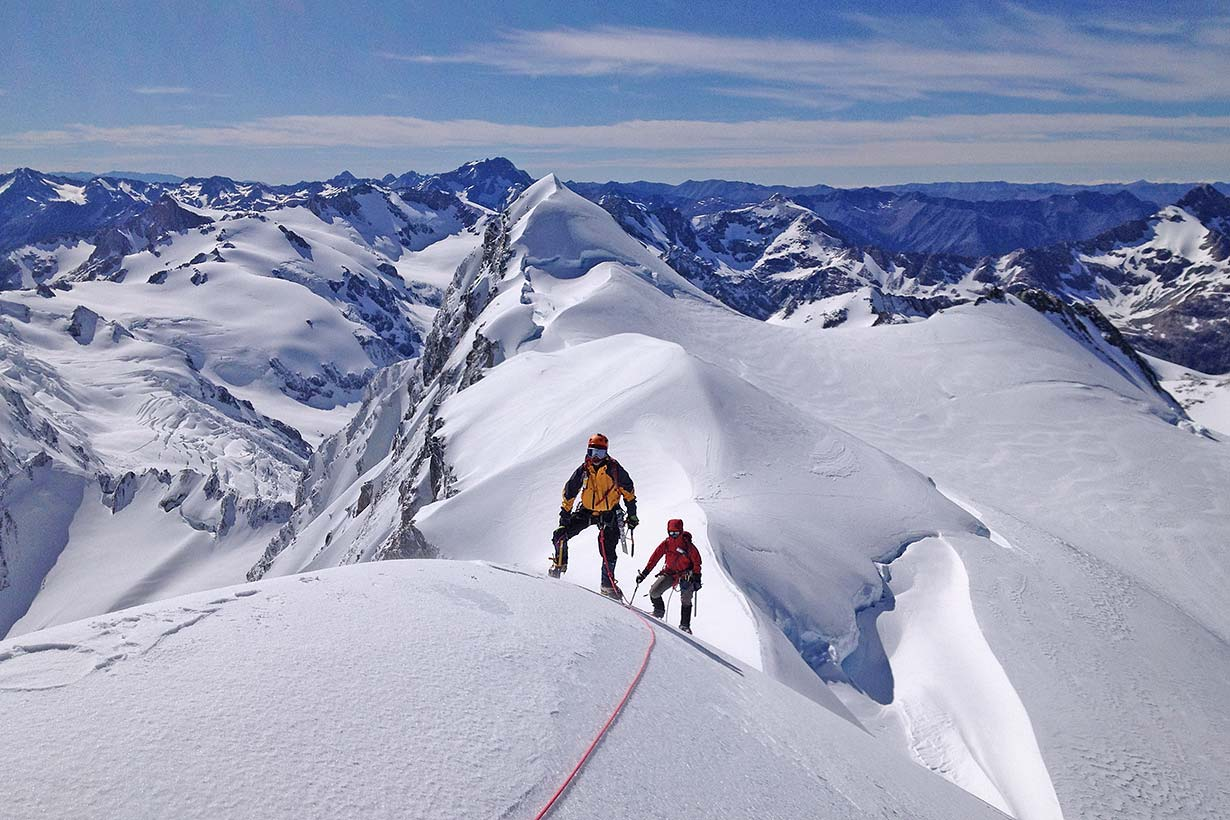

In [0]:
display(IP_Image("gory.jpg"))

In [0]:
gory = load_image('gory.jpg')
plt.figure(figsize=(12, 8))
plt.grid(False)
plt.imshow(gory)

In [0]:
output_dict = run_inference_for_single_image(gory, detection_graph)

In [0]:
%matplotlib inline

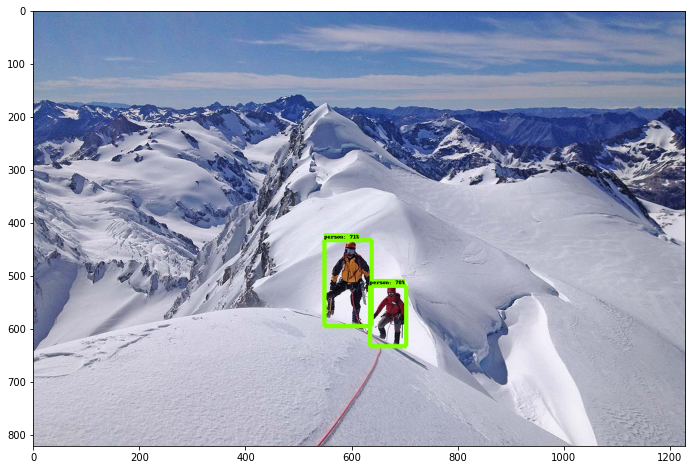

In [0]:
vis_util.visualize_boxes_and_labels_on_image_array(
      gory,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
plt.figure(figsize=(12, 8))
plt.grid(False)
plt.imshow(gory)
plt.show()

#gory1 = Image.fromarray(gory, "RGB")
#display(IP_Image(gory1))
